In [1]:
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random
import numpy as np
import os
import itertools

import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

/Users/ray/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Visualizing the data and their labels

# first set random state for consistency
np.random.seed(99)

# define a function to show an image with its label using its path in the folder
def plot_samp(letter):
    impath = './asl_alphabet_train/' + letter + '/**'
    plt.imshow(cv2.imread(glob(impath)[np.random.randint(low = 0, high = 2999)]))
    plt.title(letter)

In [3]:
# getting labels of data from folder directory as a list

# setting the directory
train_dir = './asl_alphabet_train/'
test_dir = './asl_alphabet_test/'

# list of directory
train_folders = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# taking out "ds.store"
tr_fold = train_folders[1:30]
tr_fold

['R',
 'U',
 'I',
 'N',
 'G',
 'Z',
 'T',
 'S',
 'A',
 'F',
 'O',
 'H',
 'del',
 'nothing',
 'space',
 'M',
 'J',
 'C',
 'D',
 'V',
 'Q',
 'X',
 'E',
 'B',
 'K',
 'L',
 'Y',
 'P',
 'W']

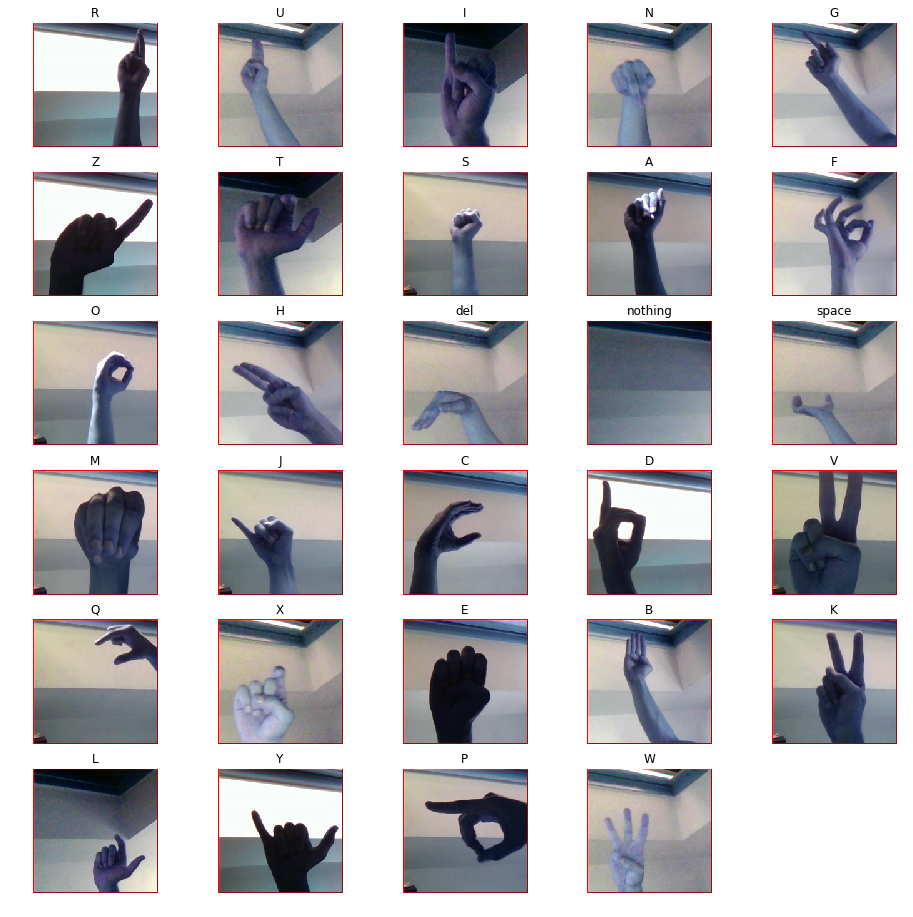

In [4]:
# setting size of each plotted image
plt.figure(figsize = (16,16))

# showing an image for every class
for i in range(len(tr_fold)):
    plt.subplot(6, 5, i + 1).axis('off') # showing the classes in 6 rows and 5 columns
    plot_samp(tr_fold[i]) # use previously created function

In [5]:
# get images in an array

x_train, y_train = [], []
for folder in tr_fold:  #for each folder in the training directory,
    files = os.listdir(train_dir + folder)  #get files from that folder name in the training directory
    print('Reading images from ' + train_dir + folder + '/ ...') #update user on which folder the code is working on
    for file in files[:1000]:  #for each file within a specific folder name
        img = cv2.imread(train_dir + folder + '/' + file) #get the images 
        img = cv2.resize(img, (64, 64)) #resize the images to 64 by 64
        x_train.append(img)  #append resized image to x_train list
        y_train.append(folder) #append label of image to y_train list
        
# normalize data
xtrain = np.divide(x_train, 255)

# change the lists into arrays        
xtrain = np.asarray(xtrain) 
y_train = np.asarray(y_train)

Reading images from ./asl_alphabet_train/R/ ...
Reading images from ./asl_alphabet_train/U/ ...
Reading images from ./asl_alphabet_train/I/ ...
Reading images from ./asl_alphabet_train/N/ ...
Reading images from ./asl_alphabet_train/G/ ...
Reading images from ./asl_alphabet_train/Z/ ...
Reading images from ./asl_alphabet_train/T/ ...
Reading images from ./asl_alphabet_train/S/ ...
Reading images from ./asl_alphabet_train/A/ ...
Reading images from ./asl_alphabet_train/F/ ...
Reading images from ./asl_alphabet_train/O/ ...
Reading images from ./asl_alphabet_train/H/ ...
Reading images from ./asl_alphabet_train/del/ ...
Reading images from ./asl_alphabet_train/nothing/ ...
Reading images from ./asl_alphabet_train/space/ ...
Reading images from ./asl_alphabet_train/M/ ...
Reading images from ./asl_alphabet_train/J/ ...
Reading images from ./asl_alphabet_train/C/ ...
Reading images from ./asl_alphabet_train/D/ ...
Reading images from ./asl_alphabet_train/V/ ...
Reading images from ./asl_al

In [6]:
dims = xtrain[0].shape
print(xtrain.shape, y_train.shape, dims)

(29000, 64, 64, 3) (29000,) (64, 64, 3)


In [7]:
#use same steps to get the final testing data set

x_fintest, y_fintest = [], []
for file in test_files:
    img = cv2.imread(test_dir + file)
    img = cv2.resize(img, (64, 64))
    x_fintest.append(img)
    y_fintest.append(file.split('_')[0])
    
xfintest = np.divide(x_fintest, 255)    

xfintest = np.asarray(xfintest) 
y_fintest = np.asarray(y_fintest)

In [8]:
print(xfintest.shape, y_fintest.shape)

(28, 64, 64, 3) (28,)


In [115]:
classes = np.unique(y_train)           # list of classes in alphabetical order
label = np.array(range(29))            # numbered label for every class
lab_dict = dict(zip(classes, label))   # dictionary connecting every class to its label

In [116]:
# creating ytrain as list of its numbered label

ytrain = []
for lab in y_train:
    ytrain.append(lab_dict[lab])

In [117]:
# creating y_fintest as list of its numbered label

yfintest = []
for lab in y_fintest:
    yfintest.append(lab_dict[lab])

In [12]:
# encoding the y labels

ytrain_enc = to_categorical(ytrain, num_classes = 29)
yfintest_enc = to_categorical(yfintest, num_classes = 29)

print(ytrain_enc.shape, yfintest_enc.shape)

(29000, 29) (28, 29)


In [13]:
# function to flip images horizontally
# this data augmentation technique is used because the ASL alphabet looks different when signed by someone who
# is right-handed vs someone who is left-handed

def flip_images(X_imgs):
    #create empty list
    X_flip = []
    
    #reset the global tensorflow graph
    tf.reset_default_graph()
    
    #set a placeholder variable
    X = tf.placeholder(tf.float32, shape = dims)
    
    # use tensorflow.image's flip_left_right function with placeholder
    tf_img1 = tf.image.flip_left_right(X)
    
    # run the tensorflow session to flip the images horizontally
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

# run the function to produce the new augmented images
flipped_images = flip_images(xtrain)

In [14]:
# similar steps as above to randomly adjust the lighting for each image

def adjust_color_images(X_imgs):
    X_color_adjust = []
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = dims)
    
    tf_img = tf.image.random_hue(X, max_delta=0.05)
    tf_img = tf.image.random_contrast(tf_img, lower=0.3, upper=1.0)
    tf_img = tf.image.random_brightness(tf_img, max_delta=0.2)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img], feed_dict = {X: img})
            X_color_adjust.extend(flipped_imgs)
    X_color_adjust = np.array(X_color_adjust, dtype = np.float32)
    return X_color_adjust

color_adjusted = adjust_color_images(xtrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Color Adjusted Image')

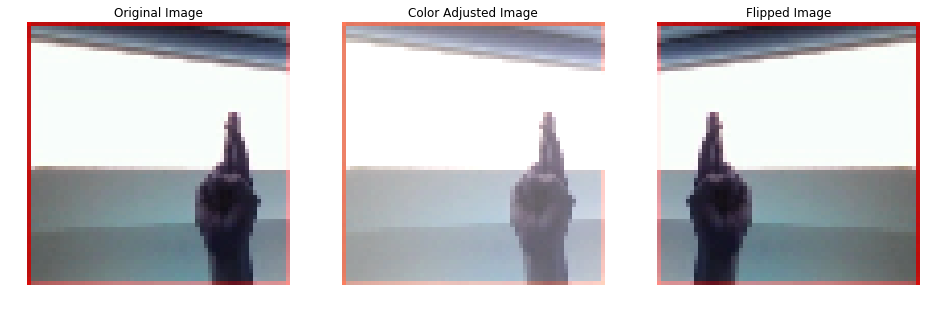

In [15]:
#plotting results of data augmentaiton

plt.figure(figsize = (16,16))

plt.subplot(1, 3, 1).axis('off')
plt.imshow(xtrain[0])
plt.title('Original Image')

plt.subplot(1, 3, 3).axis('off')
plt.imshow(flipped_images[0])
plt.title('Flipped Image')

plt.subplot(1, 3, 2).axis('off')
plt.imshow(color_adjusted[0])
plt.title('Color Adjusted Image')

In [16]:
print(xtrain.shape, flipped_images.shape, color_adjusted.shape)

(29000, 64, 64, 3) (29000, 64, 64, 3) (29000, 64, 64, 3)


In [17]:
# put all images in one list
allxtrain = np.concatenate((xtrain, flipped_images, color_adjusted), axis = 0)

# concatenate labels of training set
allytrain = np.concatenate((ytrain_enc, ytrain_enc, ytrain_enc), axis = 0)

In [18]:
print(allxtrain.shape, allytrain.shape)

(87000, 64, 64, 3) (87000, 29)


In [19]:
%%time

# shuffle the data to reduce bias in training data

xtrainshuf, ytrainshuf = shuffle(allxtrain, allytrain, random_state=0)

CPU times: user 4.83 s, sys: 31.8 s, total: 36.6 s
Wall time: 1min 53s


In [20]:
%%time

# split this data into training and testing

Xtrain, Xtest, yTrain, yTest = train_test_split(xtrainshuf, ytrainshuf, test_size = .3)

CPU times: user 5.09 s, sys: 40.1 s, total: 45.2 s
Wall time: 2min 29s


In [21]:
print(Xtrain.shape, Xtest.shape, yTrain.shape, yTest.shape)

(60900, 64, 64, 3) (26100, 64, 64, 3) (60900, 29) (26100, 29)


In [22]:
#resnet = keras.applications.resnet50.ResNet50(include_top=True, weights= None, input_tensor=None,
#                                              input_shape = dims, pooling=None, classes=29)

In [23]:
#resnet.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
#early_stop = EarlyStopping(patience = 2)
#resnet_h = resnet.fit(Xtrain, yTrain, epochs = 30, validation_split = .3, callbacks = [early_stop])

In [25]:
mod = Sequential()
mod.add(Conv2D(64, kernel_size = 3, activation = 'relu', input_shape = dims))
mod.add(Flatten())
mod.add(Dense(100, activation = 'relu'))
mod.add(Dropout(.2))
mod.add(Dense(100, activation = 'relu'))
mod.add(Dense(29, activation = 'softmax'))
mod.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
early_stop = EarlyStopping(patience = 2)
mod_h = mod.fit(xtrainshuf, ytrainshuf, epochs = 35, validation_split = .3, callbacks = [early_stop])

Train on 60899 samples, validate on 26101 samples
Epoch 1/35
60899/60899 [==============================] - 746s 12ms/step - loss: 0.8767 - acc: 0.6955 - val_loss: 0.5279 - val_acc: 0.8320
Epoch 2/35
60899/60899 [==============================] - 745s 12ms/step - loss: 0.6946 - acc: 0.7611 - val_loss: 0.4208 - val_acc: 0.8653
Epoch 3/35
60899/60899 [==============================] - 744s 12ms/step - loss: 0.5805 - acc: 0.8000 - val_loss: 0.3440 - val_acc: 0.8925
Epoch 4/35
60899/60899 [==============================] - 738s 12ms/step - loss: 0.5113 - acc: 0.8280 - val_loss: 0.3212 - val_acc: 0.8979
Epoch 5/35
60899/60899 [==============================] - 736s 12ms/step - loss: 0.4495 - acc: 0.8487 - val_loss: 0.2917 - val_acc: 0.9040
Epoch 6/35
60899/60899 [==============================] - 735s 12ms/step - loss: 0.4008 - acc: 0.8648 - val_loss: 0.2555 - val_acc: 0.9225
Epoch 7/35
60899/60899 [==============================] - 735s 12ms/step - loss: 0.3693 - acc: 0.8779 - val_loss: 0.

In [29]:
# evaluating model on the testing data

score = mod.evaluate(Xtest, yTest, verbose=0)
print("Final loss:", score[0], "  Final accuracy:", score[1])

Final loss: 0.12873956108515747   Final accuracy: 0.9636781609195403


With a testing accuracy of 96.4%, the model seems to be proficient at classifying the ASL signs.  

In [72]:
# create a list of unencoded labels for the training set

yTrain_unenc = []

for i in range(len(yTrain)):
    yTrain_unenc.append(np.argmax(yTrain[i]))

In [77]:
# using confusion matrix to see what as predicted as what

# get predicted probability distribution of classes using model for xTrain

mod_pred_y_all = mod.predict(Xtrain, verbose = 1)      

# get class with highest probability
mod_pred_y = np.argmax(mod_pred_y_all, axis = 1)

# get confusion matrix with the actual labels and the predicted labels
conmat = confusion_matrix(yTrain_unenc, mod_pred_y)

60900/60900 [==============================] - 129s 2ms/step


In [78]:
# plotting confusion matrix.  function taken straight from scikit-learn website to make confusion matrix look nice

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


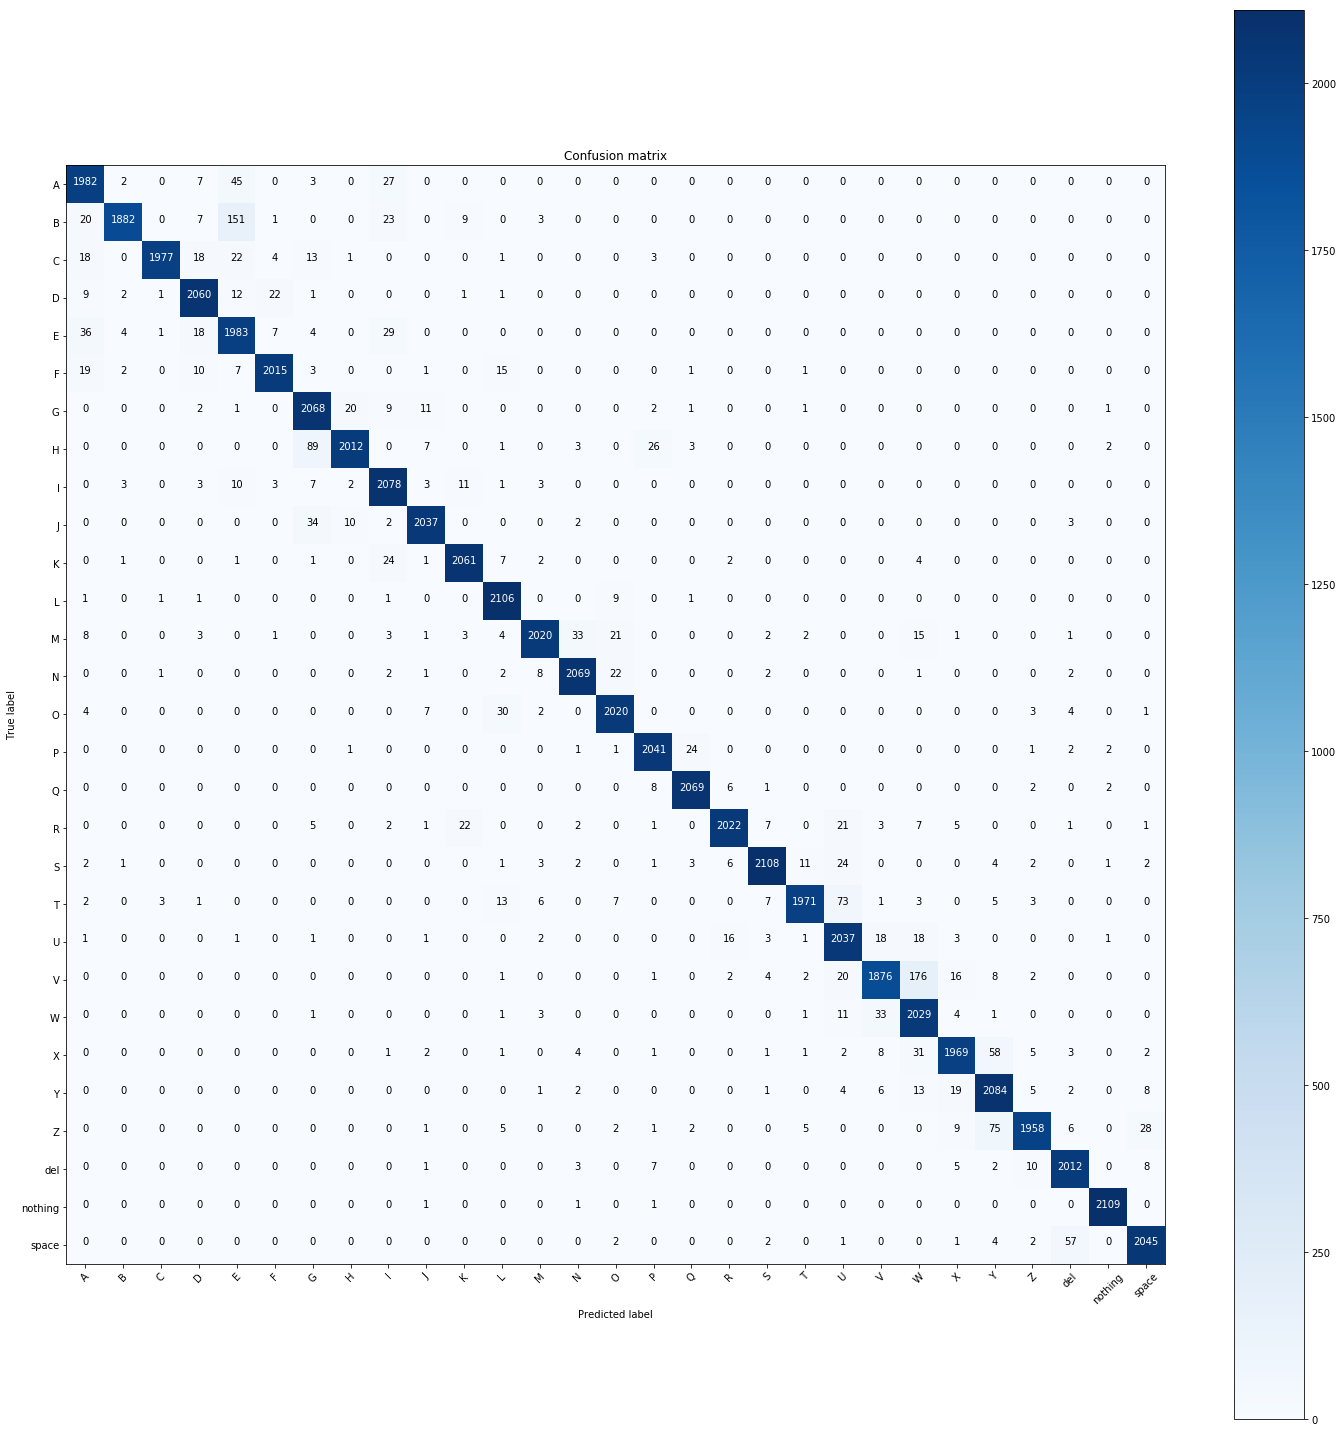

In [79]:
plt.figure(figsize = (20,20))
plot_confusion_matrix(conmat, classes)

Of note is that all the images classified 'nothing' are predicted correctly and none of the images are incorrectly classified as 'nothing'.  Given how 'nothing' is notably different from the other images, as it is the only image class that doesn't show a hand, this makes sense.

Also of note is that relatively many of the 'n' classes are misclassified as 'm'.  Given how similar the two are, this makes sense.  Curiously enough, however, the reverse is not true as most of the 'm' images are correctly classified.

Furthermore, it seems that 'o' is the label that the model most often incorrectly classifies an image as.  As the 'o' class also has the highest accuracy (besides the 'nothing' class), this could mean that the model tends to lean towards classifiy an image as 'o'.

Finally, other then the 'n' images, 'z' is the most misclassified.  In the ASL, 'z' is a moving hand motion, which could explain the relatively frequent misclassifications.  However, 'j' is the only other moving hand motion, yet it was correctly classified more often than most other classes.  The 'j' label is, however, only one of two letters (other being 'i') where the only the pinky is straight and the palms are facing out.  Curiously enough, neither of these two labels were mistaken for each other that at a high, or even average rate.

In [80]:
print(mod_h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


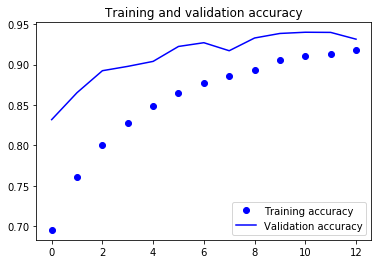

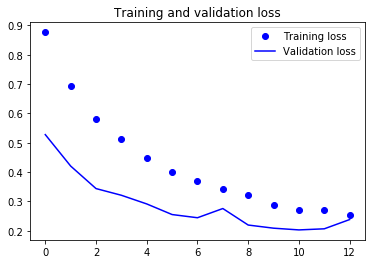

In [81]:
# using keras' History to get back accuracy and loss for training and validation set for each epoch

accuracy = mod_h.history['acc']
val_accuracy = mod_h.history['val_acc']
loss = mod_h.history['loss']
val_loss = mod_h.history['val_loss']

# epochs as length of 
epochs = range(len(accuracy))

# plotting accuracy for training and validation
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# plotting loss for training and validation
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [139]:
# looking at some missclassified pictures

# Create new arrays of which images are in/correctly classified
correct = np.nonzero(mod_pred_y == yTrain_unenc)[0]
incorrect = np.nonzero(mod_pred_y != yTrain_unenc)[0]

In [140]:
correct.shape

(58700,)

In [141]:
incorrect.shape

(2200,)

In [89]:
# confirming the shapes add up to 60900
58700 + 2200

60900

In [142]:
# import to randomize indices for later
from random import randint

In [143]:
# create list of the predicted images as their class (rather than numbered label)

class_dict = dict(zip(label, classes))

modpredclass = []
for classes0 in mod_pred_y:
    modpredclass.append(class_dict[classes0])

In [144]:
# create list of training images as their class (rather than numbered label)

trainclass = []
for classes1 in yTrain_unenc:
    trainclass.append(class_dict[classes1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

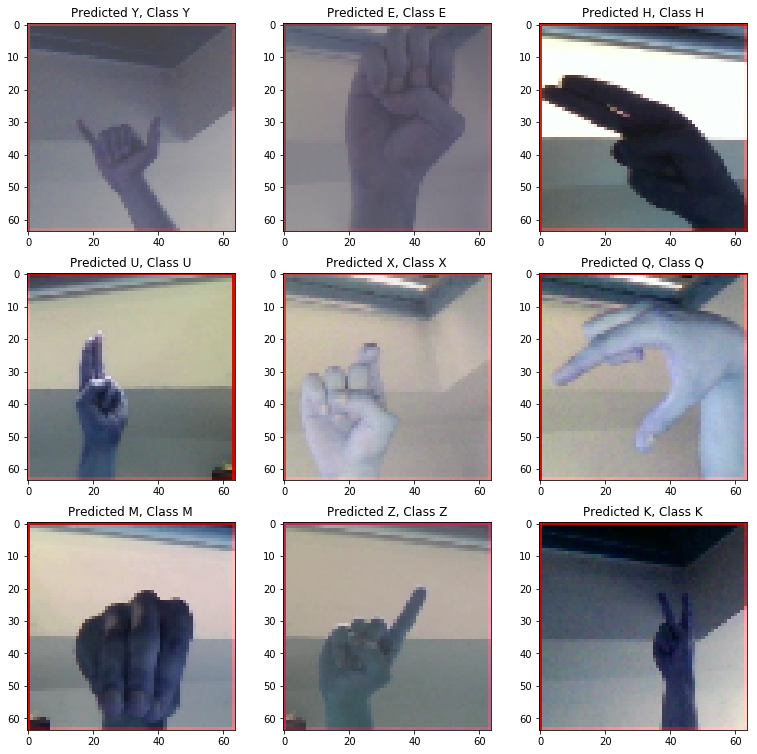

In [148]:
# plotting both correctly and incorrectly labeled images

plt.figure()
plt.figure(figsize = (13,13)) #tweaking size of each image

# getting 9 random correctly classified images
for i, corr in enumerate(correct[[randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)
        , randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)
        , randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)]]):
    plt.subplot(3,3,i+1)
    plt.imshow(Xtrain[corr].reshape(64,64,3), cmap='gray', interpolation='none')  # plot the image
    plt.title("Predicted {}, Class {}".format(modpredclass[corr], trainclass[corr])) # show image's predicted and actual class


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

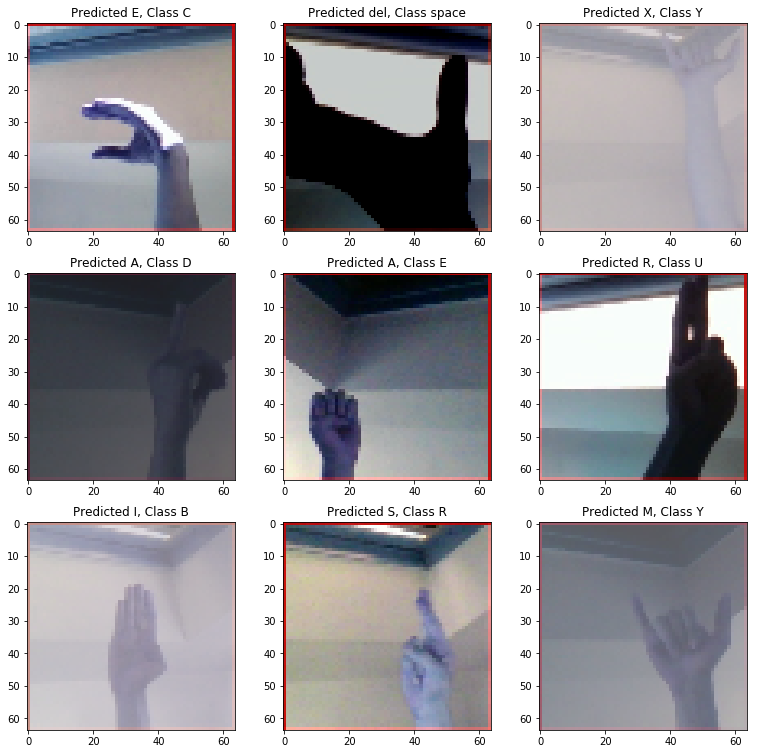

In [150]:
plt.figure()
plt.figure(figsize = (13,13))
for i, incorr in enumerate(incorrect[[randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)
        , randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)
        , randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)]]):
    plt.subplot(3,3,i+1)
    plt.imshow(Xtrain[incorr].reshape(64,64,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(modpredclass[incorr], trainclass[incorr]))

In [ ]:
"""model = Sequential()
    
model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape = dims))
model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(29, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

In [ ]:
"""early_stop = EarlyStopping(patience = 3)
model.fit(xtrain, ytrain_enc, epochs = 20, validation_split = .3, callbacks = [early_stop])"""